# Instagram Fake Account Detection

## The Dataset

### Context
Spam and fake profiles are a problem on all media platforms, including Instagram.
I would like to try and detect them using machine learning.


### Content
A kaggle user has personally identified the spammer/fake accounts included in this dataset after carefully examining each instance and as such the dataset has high level of accuracy though there might be a couple of misidentified accounts in the spammers list as well.

I'm using the k-means algorythym to cluster data, and then a random forest classifier to classify.

Finally, I'm testing my data and viewing precision and accuracy

In [28]:
# IMPORT NEEDED TOOLS 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# IMPORT DATASET
df_train = pd.read_csv('fakeAccountTrain.csv')
df_test = pd.read_csv('fakeAccountTest.csv')



df_train.describe()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,0.163837,1.460069,0.036094,0.034722,22.623264,0.116319,0.381944,107.489583,8.530724e+04,508.381944,0.500000
std,0.458047,0.214096,1.052601,0.125121,0.183234,37.702987,0.320886,0.486285,402.034431,9.101485e+05,917.981239,0.500435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.900000e+01,57.500000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.505000e+02,229.500000,0.500000
75%,1.000000,0.310000,2.000000,0.000000,0.000000,34.000000,0.000000,1.000000,81.500000,7.160000e+02,589.500000,1.000000
max,1.000000,0.920000,12.000000,1.000000,1.000000,150.000000,1.000000,1.000000,7389.000000,1.533854e+07,7500.000000,1.000000


In [29]:
# CLEANING UP DATA

df_train.rename(columns={
    'profile pic': 'profile_pic',
    'nums/length username': 'username_ratio',
    'fullname words': 'fullname_words',
    'nums/length fullname': 'name_ratio',
    'name==username': 'name_equals_username',
    'description length': 'bio_length',
    'external URL': 'has_external_url',
    'private': 'is_private',
    '#posts': 'num_posts',
    '#follows': 'num_follows',
    '#followers': 'num_followers'
}, inplace=True)

df_test.rename(columns={
    'profile pic': 'profile_pic',
    'nums/length username': 'username_ratio',
    'fullname words': 'fullname_words',
    'nums/length fullname': 'name_ratio',
    'name==username': 'name_equals_username',
    'description length': 'bio_length',
    'external URL': 'has_external_url',
    'private': 'is_private',
    '#posts': 'num_posts',
    '#follows': 'num_follows',
    '#followers': 'num_followers'
}, inplace=True)

# DROP NULL ROWS 
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)


df_train.head(10)

,profile_pic,username_ratio,fullname_words,name_ratio,name_equals_username,bio_length,has_external_url,is_private,num_posts,num_followers,num_follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0
5,1,0.00,4,0.0,0,81,1,0,344,669987,150,0
6,1,0.00,2,0.0,0,50,0,0,16,122,177,0
7,1,0.00,2,0.0,0,0,0,0,33,1078,76,0
8,1,0.00,0,0.0,0,71,0,0,72,1824,2713,0
9,1,0.00,2,0.0,0,40,1,0,213,12945,813,0


## Clustering with K-Means

In [30]:
# TRANSFORMING OUR DATA

scaler = StandardScaler()

from sklearn.preprocessing import StandardScaler

df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

# SCALE NON BINARY COLUMNS
continuous_features = ['username_ratio', 'fullname_words', 'name_ratio', 'bio_length', 'num_posts', 'num_followers', 'num_follows']
df_train_scaled[continuous_features] = scaler.fit_transform(df_train_scaled[continuous_features])
df_test_scaled[continuous_features] = scaler.fit_transform(df_test_scaled[continuous_features])

df_train_scaled.describe()


,profile_pic,username_ratio,fullname_words,name_ratio,name_equals_username,bio_length,has_external_url,is_private,num_posts,num_followers,num_follows,fake
count,576.000000,5.760000e+02,5.760000e+02,5.760000e+02,576.000000,5.760000e+02,576.000000,576.000000,576.000000,5.760000e+02,576.000000,576.000000
mean,0.701389,-9.868649e-17,4.934325e-17,2.467162e-17,0.034722,4.934325e-17,0.116319,0.381944,0.000000,-6.167906e-18,0.000000,0.500000
std,0.458047,1.000869e+00,1.000869e+00,1.000869e+00,0.183234,1.000869e+00,0.320886,0.486285,1.000869,1.000869e+00,1.000869,0.500435
min,0.000000,-7.659160e-01,-1.388312e+00,-2.887226e-01,0.000000,-6.005606e-01,0.000000,0.000000,-0.267597,-9.381039e-02,-0.554286,0.000000
25%,0.000000,-7.659160e-01,-4.374587e-01,-2.887226e-01,0.000000,-6.005606e-01,0.000000,0.000000,-0.267597,-9.376751e-02,-0.491594,0.000000
50%,1.000000,-7.659160e-01,-4.374587e-01,-2.887226e-01,0.000000,-6.005606e-01,0.000000,0.000000,-0.245191,-9.364489e-02,-0.304063,0.500000
75%,1.000000,6.832941e-01,5.133950e-01,-2.887226e-01,0.000000,3.020086e-01,0.000000,1.000000,-0.064701,-9.302302e-02,0.088443,1.000000
max,1.000000,3.534966e+00,1.002193e+01,7.710517e+00,1.000000,3.381362e+00,1.000000,1.000000,18.127401,1.677362e+01,7.622917,1.000000


In [31]:
# SEPERATE TRAINING INTO INPUT AND OUTPUT 

X_train = df_train_scaled.drop(columns=['fake']) 
y_train = df_train_scaled['fake']  

X_test = df_test_scaled.drop(columns=['fake']) 
y_test = df_test_scaled['fake']  


#SEPERATE DATA FOR RANDOM FOREST
X_train_rf = df_train.drop(columns=['fake']) 
y_train_rf = df_train['fake']  

X_test_rf = df_test.drop(columns=['fake']) 
y_test_rf = df_test['fake']  



In [32]:
#CLUSTERING DATA

#Creating a function to work out optimum number of clusters

def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #ELBOW PLOT MAKING
    fig =plt.subplots(figsize=(10,5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Interia')
    plt.grid(True)
    plt.show()

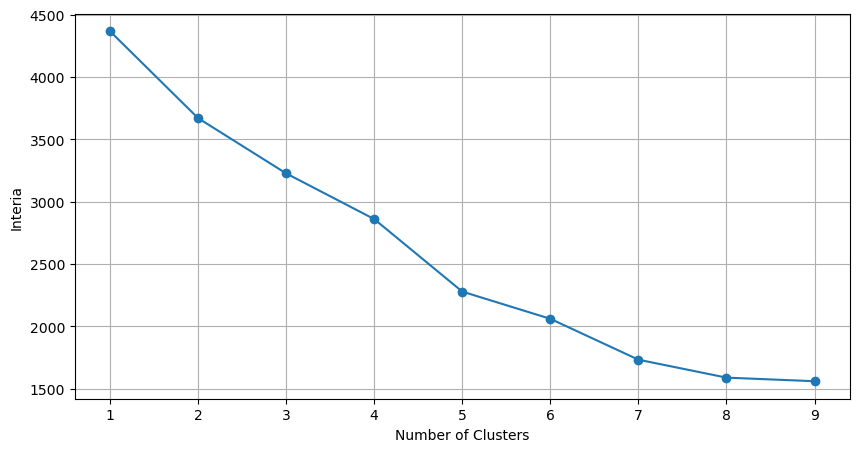

In [33]:
optimise_k_means(X_train[['profile_pic', 'username_ratio', 'fullname_words','name_ratio','name_equals_username','bio_length','has_external_url','is_private','num_posts','num_follows','num_followers']], 10)

In [34]:
# APPLYING K MEANS

kmeans = KMeans(n_clusters=7)

kmeans.fit(X_train[['profile_pic', 'username_ratio', 'fullname_words','name_ratio','name_equals_username','bio_length','has_external_url','is_private','num_posts','num_follows','num_followers']])

X_train['kmeans_7'] = kmeans.labels_

X_train

,profile_pic,username_ratio,fullname_words,name_ratio,name_equals_username,bio_length,has_external_url,is_private,num_posts,num_followers,num_follows,kmeans_7
0,1,0.496299,-1.388312,-0.288723,0,0.806385,0,0,-0.187932,-0.092711,0.486945,6
1,1,-0.765916,0.513395,-0.288723,0,0.567470,0,0,0.444404,-0.090797,0.026841,4
2,1,-0.298429,0.513395,-0.288723,0,-0.600561,0,1,-0.235233,-0.093636,-0.447437,4
3,1,-0.765916,-0.437459,-0.288723,0,1.576224,0,0,1.422782,-0.093355,0.155496,0
4,1,-0.765916,0.513395,-0.288723,0,-0.600561,0,1,-0.252659,-0.093644,-0.416909,4
...,...,...,...,...,...,...,...,...,...,...,...,...
571,1,1.805263,-0.437459,3.230943,0,-0.600561,0,0,-0.185443,-0.093628,0.095529,1
572,1,1.010535,-0.437459,2.351027,0,-0.043091,0,0,-0.158058,-0.093738,-0.472514,1
573,1,1.898761,0.513395,-0.288723,0,-0.600561,0,0,-0.257638,-0.093705,-0.184676,6
574,1,1.898761,-0.437459,-0.288723,0,-0.308553,0,0,-0.267597,-0.093748,-0.474694,6


In [35]:
# K Means must also be applied to test

kmeans = KMeans(n_clusters=7)

kmeans.fit(X_test[['profile_pic', 'username_ratio', 'fullname_words','name_ratio','name_equals_username','bio_length','has_external_url','is_private','num_posts','num_follows','num_followers']])

X_test['kmeans_7'] = kmeans.labels_

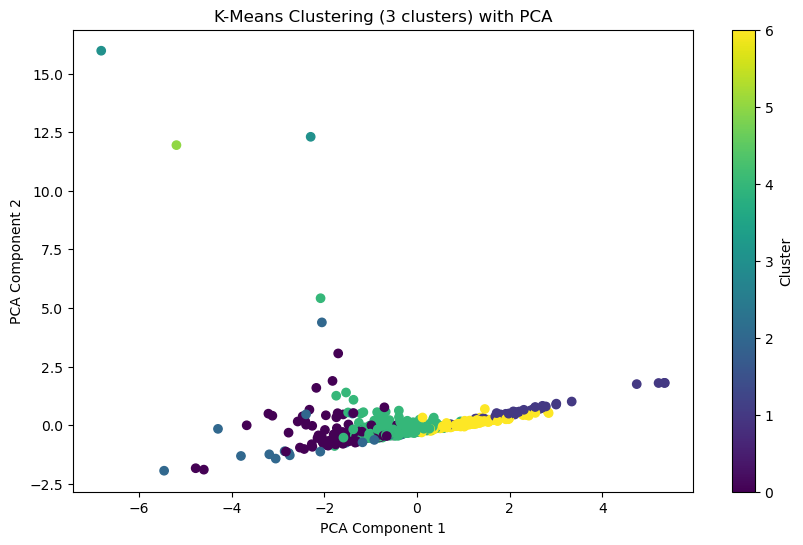

In [36]:
# REDUCE DIMENSIONS USING PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train[['profile_pic', 'username_ratio', 'fullname_words', 'name_ratio', 
                             'name_equals_username', 'bio_length', 'has_external_url', 
                             'is_private', 'num_posts', 'num_followers', 'num_follows']])

# PLOTTING PCA SCATTER
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=X_train['kmeans_7'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (3 clusters) with PCA')
plt.colorbar(label='Cluster')
plt.show()

In [37]:
# REAL AND FAKE ACCOUNT CLUSER RESULTS!

cluster_comparison = pd.crosstab(X_train['kmeans_7'], y_train)
print(cluster_comparison)

fake        0    1
kmeans_7          
0          87    6
1           1   44
2          13    6
3           2    0
4         173   88
5           1    0
6          11  144


What we can see in this case when comparing input to output is that the k means algorithm found a way to group clusters together that seem to be generally seperated correctly into fake and real accounts. 
The only cluster with a good mix is cluster 1, however the other ones are quite seperate. This will be a helpful parameter for the random forest model.

## Random Forest Classifier 

In [38]:
# RANDOM FOREST CLASSIFIER

model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train_rf, y_train_rf)

forestPredictions = model.predict(X_test_rf)
score = accuracy_score(y_test_rf, forestPredictions)


print(score)

0.9166666666666666


In [39]:
# FEATURE IMPORTANCE CHECK 

importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_rf.columns, 'Importance': importance})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

                 Feature  Importance
9          num_followers    0.304916
8              num_posts    0.224562
1         username_ratio    0.136379
0            profile_pic    0.104696
10           num_follows    0.077419
5             bio_length    0.072880
2         fullname_words    0.049246
7             is_private    0.011575
6       has_external_url    0.008058
3             name_ratio    0.007189
4   name_equals_username    0.003079


In [40]:
#VIEWING PREDICTIONS 

results_df = X_test_rf.copy()
results_df['Prediction'] = forestPredictions
results_df['True Labelsz'] = y_test_rf

results_df

,profile_pic,username_ratio,fullname_words,name_ratio,name_equals_username,bio_length,has_external_url,is_private,num_posts,num_followers,num_follows,Prediction,True Labelsz
0,1,0.33,1,0.33,1,30,0,1,35,488,604,0,0
1,1,0.00,5,0.00,0,64,0,1,3,35,6,0,0
2,1,0.00,2,0.00,0,82,0,1,319,328,668,0,0
3,1,0.00,1,0.00,0,143,0,1,273,14890,7369,0,0
4,1,0.50,1,0.00,0,76,0,1,6,225,356,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,0.29,1,0.00,0,0,0,0,13,114,811,1,1
116,1,0.40,1,0.00,0,0,0,0,4,150,164,1,1
117,1,0.00,2,0.00,0,0,0,0,3,833,3572,0,1
118,0,0.17,1,0.00,0,0,0,0,1,219,1695,1,1
